In [2]:
! pip3 install -U langchain langgraph langchain-community langchain-openai langchain-ollama

  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached marshmallow-3.26.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached typing_inspect-0.9.0-py3-none-any.whl.metadata (1.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 3.8 MB/s eta 0:00:00a 0:00:01
Using cached dataclasses_json-0.6.7-py3-none-any.whl (28 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 7.6 MB/s eta 0:00:00a 0:00:01
Using cached marshmallow-3.26.1-py3-none-any.whl (50 kB)
Using cached typing_inspect-0.9.0-py3-none-any.whl (8.8 kB)
  Attempting uninstall: langgraph
    Found existing installation: langgraph 0.6.1
    Uninstalling langgraph-0.6.1:
      Successfully uninstalled langgraph-0.6.1

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip


In [3]:
!pip3 install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.8 MB/s eta 0:00:00-:--:--
  Attempting uninstall: pip
    Found existing installation: pip 24.3.1
    Uninstalling pip-24.3.1:
      Successfully uninstalled pip-24.3.1


# simple workflow

In [11]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

In [7]:
# define state
class BMIState(TypedDict):
    weight_kg: float
    height_m: float
    bmi: float


In [8]:
def calculate_bmi(state : BMIState)-> BMIState:
    weight = state['weight_kg']
    height = state['height_m']
    bmi = weight/(height**2)
    state['bmi'] = round(bmi,2)
    return state


In [13]:
graph = StateGraph(BMIState)

graph.add_node('calculate_bmi', calculate_bmi)
graph.add_edge(START, 'calculate_bmi')
graph.add_edge('calculate_bmi',END)

workflow = graph.compile()

In [14]:
# execute
initial_state = {'weight_kg':63, 'height_m':1.73}
final_state = workflow.invoke(initial_state)
print(final_state)

{'weight_kg': 63, 'height_m': 1.73, 'bmi': 21.05}


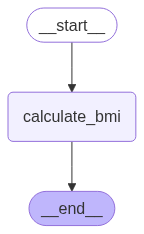

In [15]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

# complex graph

In [3]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

In [4]:
# define state
class BMIState(TypedDict):
    weight_kg: float
    height_m: float
    bmi: float
    category: str


In [5]:
def calculate_bmi(state : BMIState)-> BMIState:
    weight = state['weight_kg']
    height = state['height_m']
    bmi = weight/(height**2)
    state['bmi'] = round(bmi,2)
    return state

def label_bmi(state: BMIState)->BMIState:
    bmi = state['bmi']
    if bmi < 18.5:
        state['category'] = 'Underweight'
    elif 18.5<= bmi < 25:
        state['category'] = 'Normal'
    else:
        state['category'] = 'Obese'
    return state


In [6]:
graph = StateGraph(BMIState)

graph.add_node('calculate_bmi', calculate_bmi)
graph.add_node('label_bmi',label_bmi)
graph.add_edge(START, 'calculate_bmi')
graph.add_edge('calculate_bmi', 'label_bmi')
graph.add_edge('label_bmi',END)

workflow = graph.compile()

In [7]:
# execute
initial_state = {'weight_kg':63, 'height_m':1.73}
final_state = workflow.invoke(initial_state)
print(final_state)

{'weight_kg': 63, 'height_m': 1.73, 'bmi': 21.05, 'category': 'Normal'}


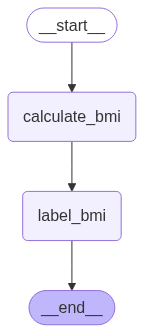

In [8]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

# LLM based workflow

In [13]:
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from typing import TypedDict

In [10]:
model_name = 'llama3.2'
model = ChatOllama(model=model_name)

In [39]:
# test model
model.invoke("hi")

AIMessage(content='How can I assist you today?', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-08-04T17:32:02.008144Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2736116583, 'load_duration': 2240841916, 'prompt_eval_count': 26, 'prompt_eval_duration': 286631083, 'eval_count': 8, 'eval_duration': 207884625, 'model_name': 'llama3.2'}, id='run--658e9eeb-e774-4265-a4d6-3db9c99fd29a-0', usage_metadata={'input_tokens': 26, 'output_tokens': 8, 'total_tokens': 34})

In [12]:
# crete state
class LLMState(TypedDict):
    question: str
    answer: str


In [14]:
def llm_qa(state: LLMState)-> LLMState:
    question = state['question']
    prompt = f'Answer the following question: {question}'
    answer = model.invoke(prompt).content
    state['answer'] = answer
    return state


In [15]:
# crete graph
graph = StateGraph(LLMState)
 # add node
graph.add_node('llm_qa', llm_qa)

graph.add_edge(START,'llm_qa')
graph.add_edge('llm_qa',END)

workflow =  graph.compile()



In [16]:
initial_state = {'question':'What is AI?'}
final_state = workflow.invoke(initial_state)
print(final_state)

{'question': 'What is AI?', 'answer': 'AI, or Artificial Intelligence, refers to the development of computer systems that can perform tasks that would typically require human intelligence, such as learning, problem-solving, decision-making, and perception.\n\nThere are several types of AI, including:\n\n1. Narrow or Weak AI: This type of AI is designed to perform a specific task, such as facial recognition or language translation.\n2. General or Strong AI: This type of AI is designed to perform any intellectual task that a human can, and has the ability to learn and improve over time.\n3. Superintelligence: This type of AI is significantly more intelligent than the best human minds, and has the potential to solve complex problems that are currently unsolvable.\n\nSome common applications of AI include:\n\n1. Virtual assistants, such as Siri or Alexa\n2. Image recognition and object detection\n3. Natural language processing (NLP) for chatbots and voice assistants\n4. Predictive analytic

In [17]:
print(final_state['answer'])

AI, or Artificial Intelligence, refers to the development of computer systems that can perform tasks that would typically require human intelligence, such as learning, problem-solving, decision-making, and perception.

There are several types of AI, including:

1. Narrow or Weak AI: This type of AI is designed to perform a specific task, such as facial recognition or language translation.
2. General or Strong AI: This type of AI is designed to perform any intellectual task that a human can, and has the ability to learn and improve over time.
3. Superintelligence: This type of AI is significantly more intelligent than the best human minds, and has the potential to solve complex problems that are currently unsolvable.

Some common applications of AI include:

1. Virtual assistants, such as Siri or Alexa
2. Image recognition and object detection
3. Natural language processing (NLP) for chatbots and voice assistants
4. Predictive analytics and machine learning algorithms
5. Self-driving ca

# prompt chaining workflow

------
* topic -> blog generate 

* start --> generate outline --> generate blog --> end

In [24]:
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from typing import TypedDict

In [25]:
model_name = 'llama3.2'
model = ChatOllama(model=model_name)

In [26]:
# crete state
class BlogState(TypedDict):
    title: str
    outline: str
    content: str


In [40]:
def create_outline(state: BlogState)->BlogState:
    title = state['title']
    print(title)
    prompt = f'Generate a detailed outline for a blog on the topic -{title}'
    outline = model.invoke(prompt).content
    state['outline'] = outline
    return state

In [41]:
def create_blog(state: BlogState)-> BlogState:
    title = state['title']
    outline = state['outline']
    prompt = f'Write a detailed blog on the title - {title} using the following outline \n{outline}'
    content = model.invoke(prompt).content
    state['content'] = content
    return state

In [45]:
# crete graph
graph = StateGraph(BlogState)
 # add node
graph.add_node('create_outline', create_outline)
graph.add_node('create_blog', create_blog)

graph.add_edge(START,'create_outline')
graph.add_edge('create_outline','create_blog')
graph.add_edge('create_blog',END)


workflow =  graph.compile()



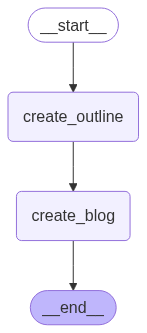

In [47]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [46]:
initial_state = {'title':'Evolution of AI'}
final_state = workflow.invoke(initial_state)
print(final_state)

Evolution of AI
{'title': 'Evolution of AI', 'outline': 'Here is a detailed outline for a blog on the evolution of AI:\n\n**I. Introduction**\n\n* Brief overview of Artificial Intelligence (AI)\n* Importance of understanding the evolution of AI\n* Thesis statement: The evolution of AI has been shaped by significant technological advancements, scientific breakthroughs, and societal needs.\n\n**II. Early Beginnings of AI (1950s-1960s)**\n\n* History of the Dartmouth Summer Research Project on Artificial Intelligence\n* Development of early AI theories and concepts (e.g., symbolic reasoning, machine learning)\n* Key figures in the early days of AI research (e.g., Alan Turing, Marvin Minsky)\n\n**III. Rule-Based Expert Systems (1970s-1980s)**\n\n* Overview of rule-based expert systems\n* Advantages and limitations of this approach\n* Examples of successful applications (e.g., medical diagnosis, financial forecasting)\n\n**IV. Machine Learning and Neural Networks (1980s-1990s)**\n\n* Introd

In [50]:
from IPython.display import Markdown, display

display(Markdown(final_state['content']))

# The Evolution of AI: A Journey from Humble Beginnings to Cutting-Edge Technology

Artificial Intelligence (AI) has come a long way since its inception in the 1950s. From humble beginnings as a theoretical concept to the sophisticated technology we know today, AI has undergone significant transformations driven by technological advancements, scientific breakthroughs, and societal needs.

## I. Introduction

The importance of understanding the evolution of AI cannot be overstated. As AI continues to shape our lives in profound ways, it is crucial to comprehend its history, current state, and future directions. This blog will take you on a journey through the evolution of AI, highlighting key milestones, breakthroughs, and challenges along the way.

## II. Early Beginnings of AI (1950s-1960s)

The Dartmouth Summer Research Project on Artificial Intelligence (1956) marked the beginning of AI as a field of research. Alan Turing's concept of the Universal Machine (1936) laid the foundation for modern computer science, while Marvin Minsky's work on neural networks and machine learning paved the way for future innovations.

Key figures like John McCarthy, who coined the term "Artificial Intelligence," and Allen Newell and Herbert Simon, who developed the first AI programming language, contributed significantly to the field's early development.

## III. Rule-Based Expert Systems (1970s-1980s)

Rule-based expert systems emerged as a prominent approach in the 1970s and 1980s. These systems relied on hand-coded rules to mimic human decision-making processes. While successful in specific domains like medical diagnosis, their limitations became apparent, particularly with complex or uncertain situations.

## IV. Machine Learning and Neural Networks (1980s-1990s)

Machine learning and neural networks revolutionized the field of AI in the 1980s and 1990s. David Rumelhart's backpropagation algorithm (1986) and Geoffrey Hinton's work on neural networks enabled the development of more sophisticated models.

Key researchers like Yann LeCun, Yoshua Bengio, and Ronald Jelinek made significant contributions to machine learning and deep learning, laying the groundwork for future breakthroughs.

## V. AI Winter and the Rise of Statistics (1990s-2000s)

The 1990s saw a decline in interest in AI, marked by the "AI winter." This period was characterized by a lack of funding, reduced research output, and decreased public enthusiasm. However, the rise of statistics and machine learning revived interest in the field.

## VI. The Dawn of Deep Learning (2010s-present)

Deep learning emerged as a dominant force in AI research in the 2010s. Techniques like convolutional neural networks (CNNs) and recurrent neural networks (RNNs) enabled significant breakthroughs in areas like:

*   Computer vision: Image recognition, object detection, and image generation
*   Natural language processing: Language translation, sentiment analysis, and text summarization
*   Speech recognition: Automatic speech recognition and voice assistants

## VII. Current State and Future Directions of AI

Current AI applications face significant challenges, including:

*   Explainability: Understanding how AI models make decisions
*   Fairness: Ensuring AI systems are unbiased and equitable
*   Safety: Preventing AI systems from causing harm or unintended consequences

Emerging trends and technologies include:

*   Edge AI: AI computing at the edge of networks, enabling real-time processing and reduced latency
*   Transfer Learning: Leveraging pre-trained models for faster adaptation to new tasks
*   Quantum AI: Exploring the potential of quantum computing for AI applications

## VIII. Conclusion

The evolution of AI has been shaped by significant technological advancements, scientific breakthroughs, and societal needs. As we move forward, it is essential to acknowledge both the benefits and challenges associated with AI.

By understanding the history and current state of AI, we can better prepare ourselves for its future impact on society, economy, and individual lives.

## Additional Sections (Optional)

*   **AI in Industry**: Exploring the role of AI in various industries, such as healthcare, finance, transportation, and education.
*   **AI Ethics and Responsibility**: Discussing the challenges and opportunities related to the responsible development and deployment of AI systems.
*   **Human-AI Collaboration**: Examining the potential benefits and limitations of human-AI collaboration in areas like creativity, problem-solving, and decision-making.

## Additional Resources (Optional)

*   List of recommended books, articles, research papers, and online courses on AI
*   Links to relevant datasets, software tools, and open-source libraries for AI development

In [51]:
# print(final_state['content'])